## Jacket Categorization

#### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Importing Dataset

In [2]:
jackets = pd.read_csv('winterjacket.csv')
jackets.head(3)

,title,type,priceWithCurrency,lastUpdated,availableText,itemLocation
0,XIYUER Women's down jacket Short 90% duck down...,Coat,US $229.00,"Oct 16, 2024 09:26:58 PDT",10 available,NaN
1,Reebok Men's Softshell Jacket,NaN,US $40.00,NaN,5 available,"Hurst, Texas, United States"
2,Mens Fleece Jacket Soft Plush Zip Up Fall Wint...,Jacket,US $14.99/ea,"Oct 16, 2024 12:16:32 PDT",4 available,"Alviso, California, United States"


### Data Cleaning

#### Rename Columns

In [3]:
jackets.rename(columns={'title':'item', 'type':'jacket_type', 'priceWithCurrency':'price', 'lastUpdated':'season', 'availableText':'available and Sold'}, inplace=True)

#### Duplicates Removal

In [4]:
jackets.duplicated().sum()

1

In [5]:
jackets.drop_duplicates(inplace=True)

#### Drop Unwanted Columns

In [6]:
jackets.drop(columns='itemLocation', inplace=True)

#### Missing Values

In [7]:
jackets.isnull().sum()

item                    1
jacket_type            19
price                   1
season                316
available and Sold    190
dtype: int64

In [8]:
jackets.dropna(subset=['item','price'],inplace=True)

#### Data Generation

In [9]:
from nltk.tokenize import word_tokenize

# lets, write a function which finds either men or women form the title
def find_gender(text):
    tokens = word_tokenize(text.lower())
    for i in tokens:
        if i == 'men' or i == 'mens':
            gender = 'Male'
            break
        elif i == 'women' or i == 'womens':
            gender = 'Female'
            break
        else:
            gender = 'both'
            break
    return gender

In [10]:
# lets, find out whether the winter jacket is for men or women
jackets['Gender'] = jackets['item'].apply(find_gender)

In [11]:
import re
# lets, create a function which converts price into rupees
def price_in_rupee(text):
    if text.startswith('US'):
        dollars = re.findall(r'[0-9]+.[0-9]{2}', text)[0]
        if ',' in dollars:
            dollars = dollars.replace(',','')
        return np.round(float(dollars) * 84.0912,2)
    elif text.startswith('GBP'):
        gbp = re.findall(r'[0-9]+.[0-9]{2}', text)[0]
        if ',' in gbp:
            gbp = gbp.replace(',','')
        return np.round(float(gbp) * 109.0627, 2)
    elif text.startswith('AU'):
        au = re.findall(r'[0-9]+.[0-9]{2}', text)[0]
        if ',' in au:
            au = au.replace(',','')
        return np.round(float(au) * 55.333, 2)
    elif text.startswith('EUR'):
        eur = re.findall(r'[0-9]+.[0-9]{2}', text)[0]
        if ',' in eur:
            eur = eur.replace(',','')
        return np.round(float(eur) * 90.9521, 2)
    elif text.startswith('C'):
        cad = re.findall(r'[0-9]+.[0-9]{2}', text)[0]
        if ',' in cad:
            cad = cad.replace(',','')
        return np.round(float(cad) * 60.5428, 2)

In [12]:
jackets['price'] = jackets['price'].apply(price_in_rupee)

In [13]:
def find_season(date):
    if str(date).endswith('PDT'):
        season = 'Summer'
    elif str(date).endswith('PST'):
        season = 'Winter'
    else:
        season = 'both'
    return season

In [14]:
jackets['season'] = jackets['season'].apply(find_season)

In [15]:
jackets['available and Sold'].fillna('0 available0 sold', inplace=True)

In [16]:
# lets, create a function which seperates the available jackets and sold out jackets
def find_quantity(text):
    data = [i.strip() for i in re.split('[0-9]+', text)]
    quantity = re.findall('[0-9]+', text)    
    
    if 'Last one' in data:
        available = 1
        if 'sold' in data:
            sold = int(quantity[0])
        else:
            sold = 0
    elif 'sold' not in data:
        available = int(quantity[0])
        sold = 0
    elif 'available' not in data:
        available = 0
        sold = int(quantity[0])
    elif 'More than' in data:
        available = np.random.randint(10, 20)
        sold = int(''.join(quantity[1:]))
    else:
        available = quantity[0]
        sold = int(''.join(quantity[1:]))
    return available, sold

In [17]:
jackets['available and Sold'] = jackets['available and Sold'].apply(find_quantity)
jackets['available'] = jackets['available and Sold'].apply(lambda x: x[0])
jackets['sold'] = jackets['available and Sold'].apply(lambda x: x[1])

In [18]:
jackets.head(3)

,item,jacket_type,price,season,available and Sold,Gender,available,sold
0,XIYUER Women's down jacket Short 90% duck down...,Coat,19256.88,Summer,"(10, 0)",both,10,0
1,Reebok Men's Softshell Jacket,NaN,3363.65,both,"(5, 0)",both,5,0
2,Mens Fleece Jacket Soft Plush Zip Up Fall Wint...,Jacket,1260.53,Summer,"(4, 0)",Male,4,0


#### Columns Infomation

In [63]:
jackets.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1998 entries, 0 to 1998
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   item                1998 non-null   object 
 1   jacket_type         1980 non-null   object 
 2   price               1998 non-null   float64
 3   season              1998 non-null   object 
 4   available and Sold  1998 non-null   object 
 5   Gender              1998 non-null   object 
 6   available           1998 non-null   object 
 7   sold                1998 non-null   int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 140.5+ KB


#### Drop Unwanted col

In [28]:
jackets.drop(columns='available and Sold', inplace=True)

#### Creating Analyzer

In [19]:
# lets, create an analyzer to do BOW
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
ps = PorterStemmer()
stop_words = set(stopwords.words('english'))

def analyzer(text):
    puncts_removed = ''.join([i.lower() for i in text if i not in string.punctuation])
    return ' '.join([ps.stem(token) for token in word_tokenize(puncts_removed) if token not in stop_words and not token.isnumeric()])

## Data Preprocessing

#### Column Transformer

In [20]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer

ct = ColumnTransformer(transformers=[('scaler', MinMaxScaler(), ['price','available','sold']),
                                     ('encoder', OrdinalEncoder(), ['Gender','season']),
                                     ('onehot', OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore'), ['jacket_type'])
                                    ], remainder='passthrough', sparse_threshold=0)

ct

ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('scaler', MinMaxScaler(),
                                 ['price', 'available', 'sold']),
                                ('encoder', OrdinalEncoder(),
                                 ['Gender', 'season']),
                                ('onehot',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['jacket_type'])])

#### Bag of Words

In [21]:
cv = CountVectorizer(analyzer=analyzer)
items = pd.DataFrame(cv.fit_transform(jackets['item']).toarray())

#### Preprocessed Data

In [22]:
jackets = pd.concat([jackets.drop(columns=['item']), items], axis=1)

#### Remove Missing values

In [23]:
jackets.dropna(inplace=True)
jackets.reset_index(inplace=True)
jackets.drop(columns='index', inplace=True)

## Pipeline

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.cluster import DBSCAN

pipe = Pipeline([('ct', ct), ('dbscan', DBSCAN(algorithm='brute',))])
jackets.columns = jackets.columns.astype(str)

#### Clusters Prediction

In [29]:
clusters = pipe.fit_predict(jackets)

## Plotting Clusters

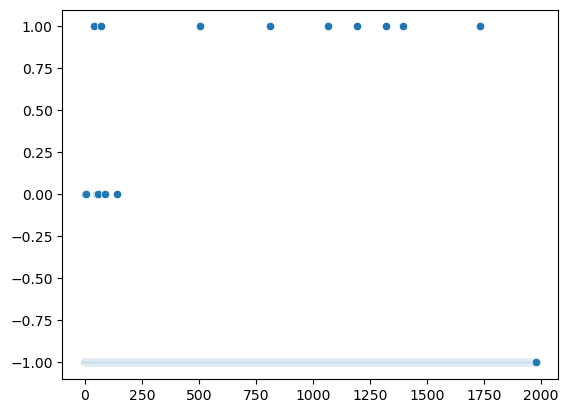

In [30]:
sns.scatterplot(clusters)
plt.show()